# Video Classification with Transformers

<img src='./images/videoTransformer01.png' width='800'> 

벤치마크 데이터셋인 UCF101 데이터셋의 서브샘플링된 버전

In [ ]:
#!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
#!tar xf ucf101_top5.tar.gz

## Setup

In [72]:
import torch
from torch import Tensor, einsum
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from einops import rearrange, repeat
from tqdm.notebook import tqdm
import math
import sys
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [4]:
torchvision.__version__

'0.9.0+cu111'

## Define hyperparameters

In [21]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1000
IMG_SIZE = 224

## Data preparation

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [78]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
589,v_TennisSwing_g25_c02.avi,TennisSwing
590,v_TennisSwing_g25_c03.avi,TennisSwing
591,v_TennisSwing_g25_c04.avi,TennisSwing
592,v_TennisSwing_g25_c05.avi,TennisSwing


In [105]:
import time 
import ipywidgets as widgets 
import IPython.display as display 
import copy 

cap = cv2.VideoCapture('./train/v_CricketShot_g08_c02.avi') 
wImg = widgets.Image( layout = widgets.Layout(border="solid") ) 
display.display(wImg) 

if cap.isOpened(): 
    ret, img = cap.read() 
    while ret: 
        tmpStream = cv2.imencode(".jpeg", img)[1].tostring() 
        wImg.value = tmpStream 
        time.sleep(0.05) 
        ret, img = cap.read() 
cap.release()


Image(value=b'', layout="Layout(border='solid')")

In [26]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def crop_center(frame):
    cropped = preprocess(frame)
    cropped = cropped.numpy().squeeze()
    return cropped

def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # 정상적으로 읽어왔는지 -> retval
            # 읽어온 프레임 -> frame
            ret, frame = cap.read()
            if not ret:
                break
                
            frame = crop_center(frame)
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [12]:
feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)
feature_extractor.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
classes = train_df['tag'].unique()

In [14]:
classes

array(['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard',
       'TennisSwing'], dtype=object)

In [53]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    classes = train_df['tag'].unique()
    labels = df["tag"].values
    labels = np.array(list(map(lambda x: np.where(classes==x), labels)))
    labels = labels.squeeze(1)

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(tqdm(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        
        
        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, 3, IMG_SIZE, IMG_SIZE))
            frames = np.concatenate(frames, padding)
            

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) != 0.0:
                    with torch.no_grad():
                        output = feature_extractor(
                            torch.FloatTensor(batch[None, j, :]).to(device)
                        ).detach().cpu().clone()
                        temp_frame_featutes[i, j, :] = output[0]
                        
                else:
                    temp_frame_featutes[i, j, :] = 0.0
        frame_features[idx,] = temp_frame_featutes.squeeze()

    return frame_features, labels

In [54]:
train_data, train_labels = prepare_all_videos(train_df, './train')
test_data, test_labels = prepare_all_videos(test_df, './test')

In [29]:
class CustomDataset(Dataset): 
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index): 
        return self.x[index], self.y[index]

In [85]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, 
                                                    test_size=0.15, 
                                                    shuffle=True,
                                                    stratify=train_labels, 
                                                    random_state=72)

In [90]:
from collections import Counter
Counter(y_train.squeeze())

Counter({4: 99, 3: 100, 1: 102, 0: 100, 2: 103})

In [91]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 8,
          'pin_memory' : True}

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.LongTensor(y_val)
x_test = torch.FloatTensor(test_data)
y_test = torch.LongTensor(test_labels)

tr_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
trainloader = DataLoader(dataset=tr_dataset, **params)
validloader = DataLoader(dataset=val_dataset, **params)

In [32]:
print(f'Train : {len(x_train)}, Valid: {len(x_val)}, Test : {len(x_test)}')

Train : 504, Valid: 90, Test : 224


## Building the Transformer-based model

In [33]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [34]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

In [35]:
class classifier(nn.Module):
    def __init__(self, 
                 num_classes, 
                 num_frames, 
                 dim = 1000, 
                 depth = 4, 
                 heads = 3, 
                 dim_head = 1, 
                 dropout = 0.,
                 emb_dropout = 0., 
                 scale_dim = 4, 
                ):
        super().__init__()
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, dim))
        self.transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x += self.pos_embedding
        x = self.transformer(x)
        x = torch.max(x, axis=1).values
        x = self.dropout(x)
        x = self.mlp_head(x)
        return x

In [58]:
params = {
    'num_classes': len(classes),
    'num_frames': MAX_SEQ_LENGTH,
    'dim': NUM_FEATURES,
    'depth': 1,
    'heads': 1,
    'dim_head': 4,
    'dropout': 0.5
}

model = classifier(**params)
summary(model, (594, 20, NUM_FEATURES))

Layer (type:depth-idx)                             Output Shape              Param #
classifier                                         --                        --
├─Transformer: 1-1                                 [594, 20, 1000]           --
│    └─LayerNorm: 2-1                              [594, 20, 1000]           2,000
├─Dropout: 1-2                                     [594, 1000]               --
├─Sequential: 1-3                                  [594, 5]                  --
│    └─LayerNorm: 2-2                              [594, 1000]               2,000
│    └─Linear: 2-3                                 [594, 5]                  5,005
Total params: 8,035,005
Trainable params: 8,035,005
Non-trainable params: 0
Total mult-adds (G): 4.77
Input size (MB): 47.52
Forward/backward pass size (MB): 861.28
Params size (MB): 32.14
Estimated Total Size (MB): 940.94

In [59]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.CrossEntropyLoss()

## Utility functions for training

In [38]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, [x, y] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
        
        input = x.to(device)
        target = y.squeeze().to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, target)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss/len(train_data)

In [39]:
def validation(model, val_data, loss_fn):
    model.eval()
    val_loss = 0
    for idx, [x, y] in enumerate(val_data):
        input = x.to(device)
        target = y.squeeze().to(device)
        with torch.no_grad():
            predictions = model.forward(input)
            val_loss += loss_fn(predictions, target)
        
    return val_loss.item()/len(val_data)

In [40]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [60]:
%%time
epochs = 100
history = dict()
best = {"loss": sys.float_info.max}
early_stopping = EarlyStopping(patience=30, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=True)
    val_loss = validation(model, validloader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    
#     sys.stdout.write(
#         "\r" + f"[Train] Epoch : {epoch:^3}"\
#         f"  Train Loss: {epoch_loss:.4}"\
#         f"  Validation Loss: {val_loss:.4}"\
#                     )
    print(f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Validation Loss: {val_loss:.4}")
    if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = epoch + 1
    if early_stopping.validate(val_loss):
        break

[Train] Epoch :  1   Train Loss: 0.6624  Validation Loss: 0.1354
[Train] Epoch :  2   Train Loss: 0.07264  Validation Loss: 0.1129
[Train] Epoch :  3   Train Loss: 0.03521  Validation Loss: 0.04676
[Train] Epoch :  4   Train Loss: 0.005942  Validation Loss: 0.007134
[Train] Epoch :  5   Train Loss: 0.004439  Validation Loss: 0.01578
[Train] Epoch :  6   Train Loss: 0.006444  Validation Loss: 0.022
[Train] Epoch :  7   Train Loss: 0.002268  Validation Loss: 0.003101
[Train] Epoch :  8   Train Loss: 0.001029  Validation Loss: 0.008251
[Train] Epoch :  9   Train Loss: 0.0002349  Validation Loss: 0.005282
[Train] Epoch : 10   Train Loss: 0.0002216  Validation Loss: 0.003444
[Train] Epoch : 11   Train Loss: 0.0001571  Validation Loss: 0.00281
[Train] Epoch : 12   Train Loss: 0.000142  Validation Loss: 0.002755
[Train] Epoch : 13   Train Loss: 0.00012  Validation Loss: 0.002813
[Train] Epoch : 14   Train Loss: 0.0001072  Validation Loss: 0.002918
[Train] Epoch : 15   Train Loss: 9.673e-05  V

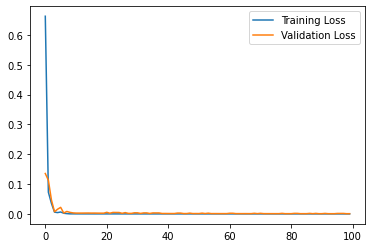

In [92]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(best["state"])

## Model training and inference

Test video path: v_TennisSwing_g02_c05.avi


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


  TennisSwing: 99.25%
  CricketShot:  0.74%
  Punch:  0.01%
  PlayingCello:  0.00%
  ShavingBeard:  0.00%


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0


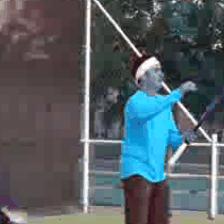

In [93]:
def prepare_single_video(frames):
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) != 0.0:
                frame_featutes[i, j, :] = feature_extractor(
                    torch.FloatTensor(batch[None, j, :]).to(device)
                ).detach().cpu().clone().numpy()
            else:
                frame_featutes[i, j, :] = 0.0

    return frame_featutes


def predict_action(path):
    class_vocab = classes

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    model.eval()
    probabilities = model.forward(torch.FloatTensor(frame_features).to(device))[0].detach().cpu().clone()
    probabilities = torch.nn.functional.softmax(probabilities, dim=0).numpy()
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i]*100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images#.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
test_frames = rearrange(test_frames, 'n c h w -> n h w c')
to_gif(test_frames[:MAX_SEQ_LENGTH])

---